In [ ]:
# 1. Thêm các thư viện cần thiết và function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, ReLU
from keras.datasets import cifar10
from keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow 
import cv2 as cv
import random
import time

def Denoise(input_shape=(32,32,3)):
  
  X_input = Input(input_shape)
  
  X = Conv2D(32, (3, 3),strides=2, padding='same')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  
  X = Conv2D(64, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  X = Conv2D(128, (3, 3),strides=2, padding='same')(X) 
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  X = Conv2D(256, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(256, (3, 3),strides=1, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(256, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  X = Conv2DTranspose(128, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(64, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(32, (3, 3),strides=2, padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(3, (3,3),strides=1,padding='same')(X)
  X = Activation('sigmoid')(X)
  
  model = Model(inputs = X_input, outputs = X, name='Autoencoder')
  
  return model

def noisy(x):
  noise = np.random.normal(loc=0.0, scale=0.1, size=x.shape)
  x = x + noise
  x = x.clip(0.,1.)
  
  return x

def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()

#2. Load và preprocessing ảnh
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# 3.Thêm noise vào ảnh
X_train_noisy = noisy(X_train)
X_test_noisy = noisy(X_test)


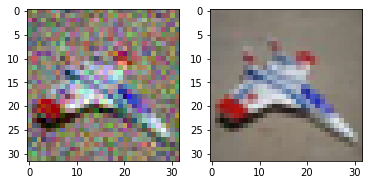

In [ ]:
plt.subplot(1,2,1)
plt.imshow(X_train_noisy[30])
plt.subplot(1,2,2)
plt.imshow(X_train[30])
plt.show()

In [ ]:
# 4. Định nghĩa model
model = Denoise(input_shape = (32, 32, 3))

# 5. Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức 
# dùng để tối ưu hàm loss function, callback
model.compile(loss='mse',
              optimizer='adam')

callback = [ModelCheckpoint('best_model.h5', 
                            verbose=1, 
                            save_best_only=True, 
                            save_weights_only=True)]

# 6. Thực hiện train model với data
H = model.fit(X_train_noisy, X_train,
              validation_data=(X_test_noisy, X_test),
              batch_size=256, 
              epochs=40, 
              verbose=1, 
              callbacks = callback)

Epoch 1/40
196/196 [==============================] - 11s 50ms/step - loss: 0.0453 - val_loss: 0.0183

Epoch 00001: val_loss improved from inf to 0.01826, saving model to best_model.h5
Epoch 2/40
196/196 [==============================] - 9s 47ms/step - loss: 0.0170 - val_loss: 0.0124

Epoch 00002: val_loss improved from 0.01826 to 0.01238, saving model to best_model.h5
Epoch 3/40
196/196 [==============================] - 9s 47ms/step - loss: 0.0122 - val_loss: 0.0109

Epoch 00003: val_loss improved from 0.01238 to 0.01087, saving model to best_model.h5
Epoch 4/40
196/196 [==============================] - 9s 47ms/step - loss: 0.0106 - val_loss: 0.0097

Epoch 00004: val_loss improved from 0.01087 to 0.00974, saving model to best_model.h5
Epoch 5/40
196/196 [==============================] - 9s 47ms/step - loss: 0.0096 - val_loss: 0.0089

Epoch 00005: val_loss improved from 0.00974 to 0.00887, saving model to best_model.h5
Epoch 6/40
196/196 [==============================] - 9s 47ms/s

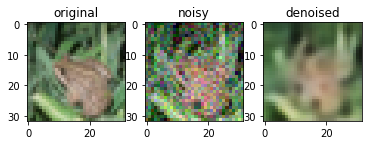

In [ ]:
# 7. Load model tốt nhất
model.load_weights('best_model.h5')
X_test_denoised = model.predict(X_test_noisy)

# 8. Load ảnh sau khi được denoise
idx = 4

plt.subplot(1,3,1)
plt.imshow(X_test[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(X_test_noisy[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(X_test_denoised[idx])
plt.title('denoised')
plt.show()

In [ ]:
# 9. Evaluate model
clean_noisy = mse(X_test, X_test_noisy)
clean_denoised = mse(X_test, X_test_denoised)

clean_noisy, clean_denoised

(0.009304637019732168, 0.003978729)